<a href="https://colab.research.google.com/github/ritwiks9635/New_Project_Ideas/blob/main/Gensim_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [4]:
data = pd.read_csv("simpsons_dataset.csv")
data.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


In [5]:
data.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

In [6]:
data = data.dropna().reset_index(drop = True)
data.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

In [7]:
nlp = spacy.load(("en_core_web_sm"), disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data['spoken_words'])

In [ ]:
##Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [10]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.31 mins


In [9]:
##Put the results in a DataFrame to remove missing values and duplicates:

In [11]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85955, 1)

In [12]:
## We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

In [13]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
##As Phrases() takes a list of list of words as input:

In [14]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
#$ Creates the relevant phrases from the list of sentences:

In [15]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [16]:
bigram = Phraser(phrases)

In [ ]:
##Transform the corpus based on the bigrams detected:

In [18]:
sentences = bigram[sent]

Most Frequent Words:¶
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [24]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29694

In [25]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

Gensim Word2Vec Implementation:¶

In [26]:
import multiprocessing

from gensim.models import Word2Vec

Why I seperate the training of the model in 3 steps:

I prefer to separate the training in 3 distinctive steps for clarity and monitoring.

Word2Vec():
In this first step, I set up the parameters of the model one-by-one.
I do not supply the parameter sentences, and therefore leave the model uninitialized, purposefully.
.build_vocab():
Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, I can follow the progress and even more important, the effect of min_count and sample on the word corpus. I noticed that these two parameters, and in particular sample, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.


.train():
Finally, trains the model.
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [27]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

2

The parameters:min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
size = int - Dimensionality of the feature vectors. - (50, 300)
sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
alpha = float - The initial learning rate - (0.01, 0.05)
min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [29]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

In [30]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


Training of the model:¶
Parameters of the training:
total_examples = int - Count of sentences;epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [31]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.68 mins


Exploring the model¶Most similar to:
Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

In [32]:
w2v_model.init_sims(replace=True)

<ipython-input-32-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [33]:
w2v_model.wv.most_similar(positive=["homer"])

[('marge', 0.7518449425697327),
 ('sorry', 0.690482497215271),
 ('fault', 0.6877033710479736),
 ('gee', 0.6859760880470276),
 ('bongo', 0.6854003667831421),
 ('depressed', 0.6810348033905029),
 ('snuggle', 0.6679742336273193),
 ('shoulda', 0.6641676425933838),
 ('get_to', 0.661881148815155),
 ('grownup', 0.6602857112884521)]

In [34]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulation', 0.7077516317367554),
 ('request', 0.685884416103363),
 ('select', 0.6763788461685181),
 ('council', 0.6747541427612305),
 ('simon', 0.670991063117981),
 ('robert', 0.6639096140861511),
 ('distract', 0.6634641289710999),
 ('versus', 0.6619045734405518),
 ('recent', 0.6585252285003662),
 ('easily', 0.6560796499252319)]

In [35]:
w2v_model.wv.most_similar(positive=["marge"])

[('homer', 0.7518450021743774),
 ('humiliate', 0.6851760149002075),
 ('homie', 0.683857798576355),
 ('becky', 0.6812477111816406),
 ('badly', 0.6799058318138123),
 ('sorry', 0.6763675212860107),
 ('affair', 0.6747133731842041),
 ('fault', 0.6685531139373779),
 ('sweetheart', 0.6672972440719604),
 ('snuggle', 0.664254367351532)]

In [36]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8027445673942566),
 ('mom', 0.7508401870727539),
 ('mom_dad', 0.7505117654800415),
 ('embarrassing', 0.7288551330566406),
 ('hearing', 0.7225304841995239),
 ('babysitter', 0.7214469313621521),
 ('bedtime', 0.7209573984146118),
 ('behave', 0.7185682058334351),
 ('strangle', 0.7158151268959045),
 ('convince', 0.7125563025474548)]

In [38]:
w2v_model.wv.similarity('maggie', 'baby')

0.64326

In [39]:
w2v_model.wv.similarity('bart', 'nelson')

0.5579837

In [41]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [42]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

'homer'

In [43]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('lisa', 0.6878495216369629),
 ('parent', 0.6477975249290466),
 ('pregnant', 0.6335086822509766)]

t-SNE visualizations:

In [44]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [47]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

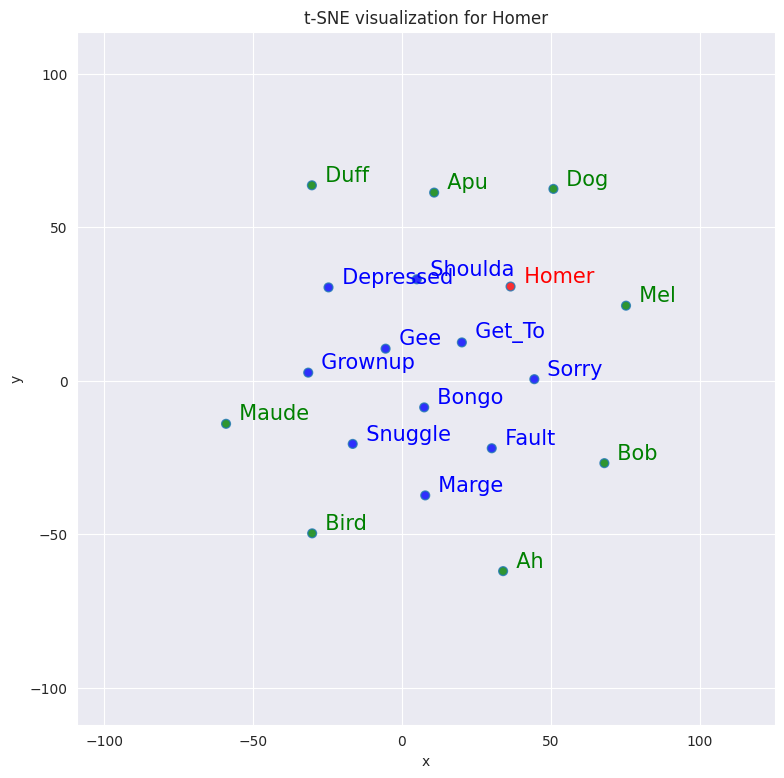

In [48]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

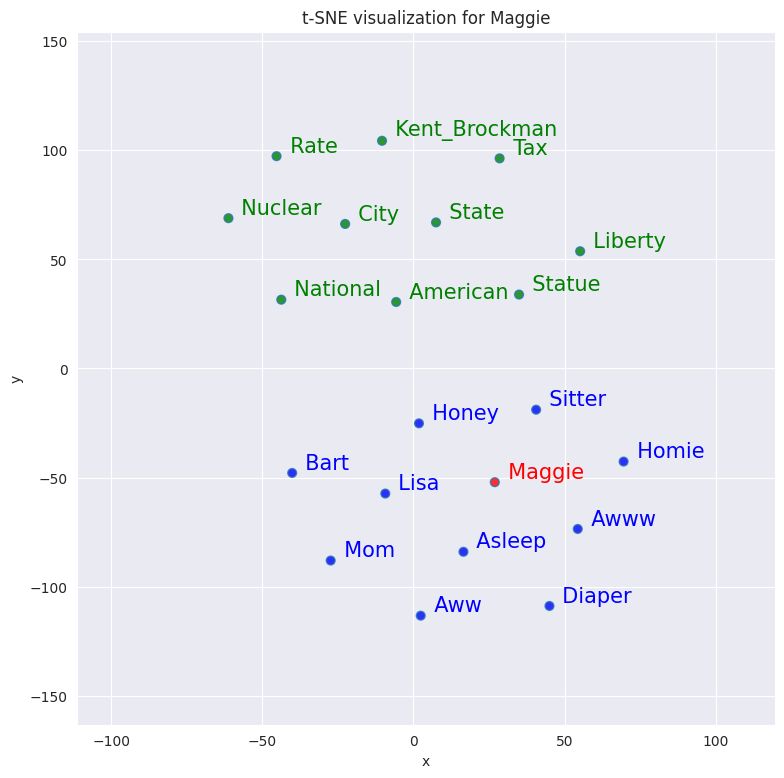

In [49]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

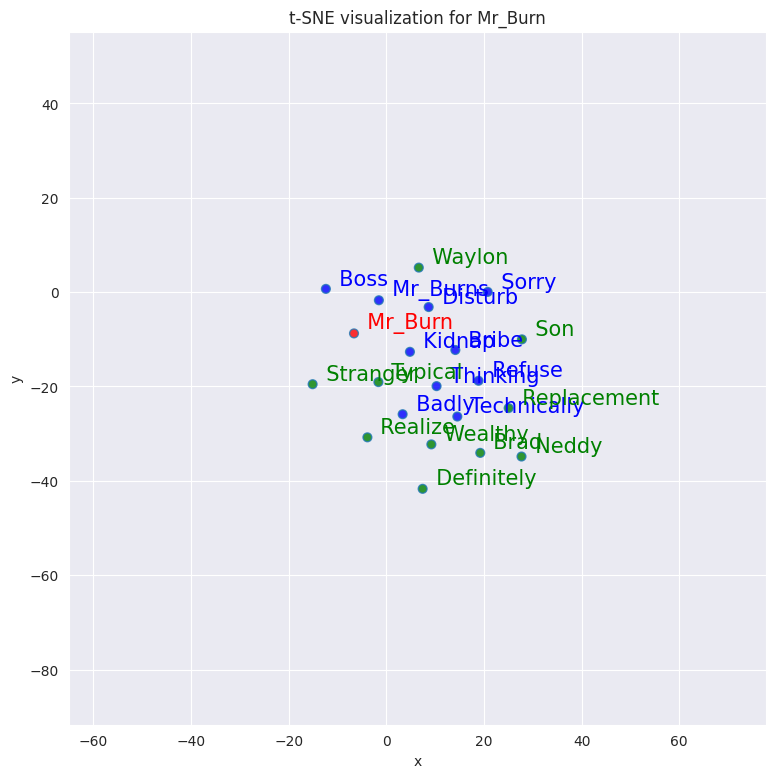

In [50]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])

Materials for more in depths understanding:¶Word Embeddings introduction: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/Word2Vec introduction: https://skymind.ai/wiki/word2vecAnother Word2Vec introduction: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/A great Gensim implentation tutorial: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2xOriginal articles from Mikolov et al.: https://arxiv.org/abs/1301.3781 and https://arxiv.org/abs/1310.4546